In [4]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sklearn.linear_model as skl
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn import linear_model
import random as rd
from sklearn.utils import resample

C:\Users\mathi\AppData\Local\Temp\ipykernel_12092\4273616348.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


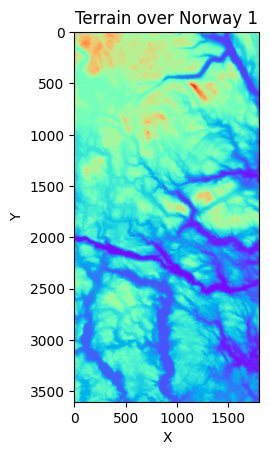

In [5]:
np.random.seed(4231)

# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='rainbow')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

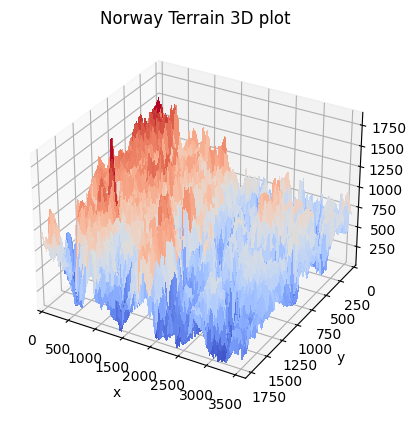

In [6]:
rows, cols = terrain1.shape

fig=plt.figure()
ax=fig.add_subplot(projection='3d')

x, y = np.meshgrid(range(rows), range(cols))

# Plot the surface.
surf = ax.plot_surface(x.T, y.T, terrain1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.xlabel('x')
plt.ylabel('y')
ax.set_xlim(0,rows)
ax.set_ylim(cols, 0)

plt.title("Norway Terrain 3D plot")
plt.show()

(3000, 2)


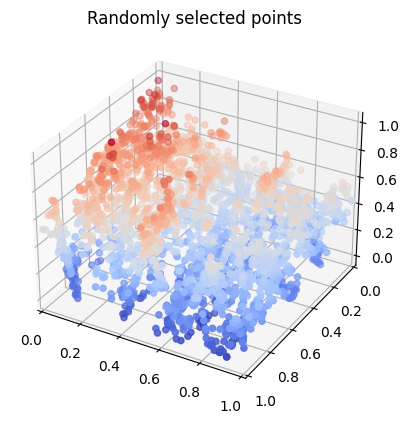

In [7]:
def min_max_scaler(data):
    """
    Perform Min-Max scaling on a given dataset.

    Min-Max scaling rescales the values in the input array 'X' to a given range
    .
    Parameters:
    x (np.array): The input dataset to be scaled.

    Returns:
    scaled(np.array): The scaled dataset with values in the range [0, 1].
    """
    min_i = min(data)
    max_i = max(data)
    
    scaled = (data-min_i)/(max_i-min_i)
    return scaled

def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

#Select n amount of data points to shorten running time
n = 3000

datapoints = np.zeros([n, 2])
z = np.zeros([n, 1])

datapoints = np.column_stack((np.random.randint(0, rows, size = n), np.random.randint(0, cols, size = n)))
print(datapoints.shape)
for i in range(n):
    z[i] = terrain1[int(datapoints[i, 0])][int(datapoints[i, 1])]

z = min_max_scaler(z)
datapoints = np.column_stack((min_max_scaler(datapoints[:,0]), min_max_scaler(datapoints[:,1])))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y = np.meshgrid(range(rows), range(cols))

scatter = ax.scatter(datapoints[:, 0], datapoints[:, 1], z, c = z, cmap=cm.coolwarm, marker='o', label='Selected Points')
plt.title("Randomly selected points")
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
plt.show()


In [8]:
def c_tilde(deg, x):
    """
    Generate a subset of features from the input data matrix 'x' up to a specified degree 'deg',
    to use in predicting MSE and R2 score.

    Parameters:
    deg (int): The desired degree up to which features should be generated.
    x (np.array): The input data matrix containing one or more columns of features.

    Returns:
    c (int): The number of features generated up to degree 'i'.
    tilde (np.array): calculated tilde value of input
    """
    c = int((deg + 2) * (deg + 1) / 2)
    tilde = x[:,0:c-1]
    return c, tilde

PolynomialDegree = 20

#create design matrix X
X = create_X(datapoints[:, 0], datapoints[:, 1], PolynomialDegree)

#Remove intercept
X = X[:, 1:]

#Split into train and test sets
x_train, x_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)

train error:0.009164867669161128
test error:0.012664395706351144


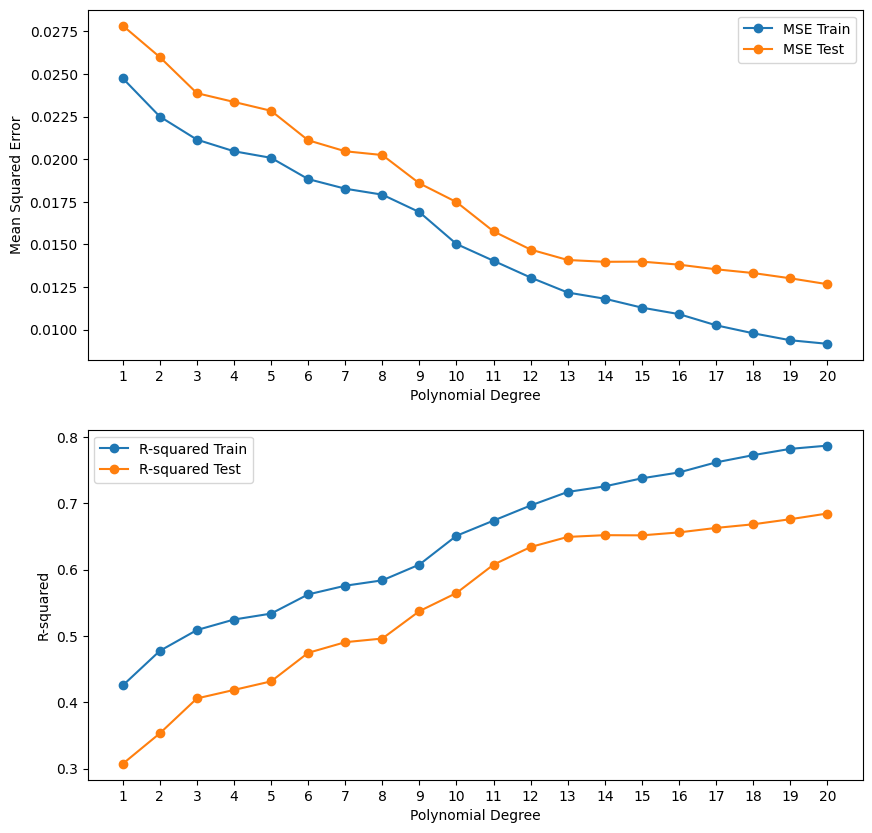

In [9]:
##OLS

MSETrain = np.zeros(PolynomialDegree)
MSETest = np.zeros(PolynomialDegree)
R2Train = np.zeros(PolynomialDegree)
R2Test = np.zeros(PolynomialDegree)

for degree in range(1, PolynomialDegree + 1):
    c, Xtilde = c_tilde(degree, x_train)

    model = LinearRegression(fit_intercept=True)
    model.fit(Xtilde, z_train)

    ztilde = model.predict(Xtilde)
    z_pred = model.predict(x_test[:, 0:c-1])

    MSETrain[degree-1] = mean_squared_error(z_train, ztilde)
    MSETest[degree-1] = mean_squared_error(z_test, z_pred)
    R2Train[degree-1] = r2_score(z_train, ztilde)
    R2Test[degree-1] = r2_score(z_test, z_pred)
degrees = np.arange(1, PolynomialDegree + 1)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot MSE for train and test data
axes[0].plot(degrees, MSETrain, label='MSE Train', marker='o')
axes[0].plot(degrees, MSETest, label='MSE Test', marker='o')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_xticks(ticks = degrees)
axes[0].legend()

# Plot R2 for train and test data
axes[1].plot(degrees, R2Train, label='R-squared Train', marker='o')
axes[1].plot(degrees, R2Test, label='R-squared Test', marker='o')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('R-squared')
axes[1].set_xticks(ticks = degrees)
axes[1].legend()

print(f"train error:{MSETrain[19]}")
print(f"test error:{MSETest[19]}")

In [10]:
##Ridge
nlambdas = 100
lambdas = np.logspace(-8, 2, nlambdas)

MSETrain = np.zeros((nlambdas, PolynomialDegree))
MSETest = np.zeros((nlambdas, PolynomialDegree))
R2Train = np.zeros((nlambdas, PolynomialDegree))
R2Test = np.zeros((nlambdas, PolynomialDegree))   


for lmbd in range(nlambdas):
    for degree in range(1, PolynomialDegree + 1):    
        c, Xtilde = c_tilde(degree, x_train)
        model = linear_model.Ridge(lambdas[lmbd])
        model.fit(Xtilde, z_train)

        ztilde = model.predict(Xtilde)
        z_pred = model.predict(x_test[:,0:c-1])

        MSETrain[lmbd, degree -1] = mean_squared_error(z_train, ztilde)
        MSETest[lmbd, degree-1] = mean_squared_error(z_test, z_pred)
        R2Train[lmbd, degree-1] = r2_score(z_train, ztilde)
        R2Test[lmbd, degree-1] = r2_score(z_test, z_pred)




Degree 1: Minimum MSE Test = 0.027577363865417173 (Lambda = 31.25715849688235)
Degree 2: Minimum MSE Test = 0.025974693217749846 (Lambda = 0.4750810162102793)
Degree 3: Minimum MSE Test = 0.023874556704130474 (Lambda = 1e-08)
Degree 4: Minimum MSE Test = 0.023358968021069 (Lambda = 1e-08)
Degree 5: Minimum MSE Test = 0.02284009745720544 (Lambda = 1e-08)
Degree 6: Minimum MSE Test = 0.02111047576606613 (Lambda = 1e-08)
Degree 7: Minimum MSE Test = 0.02044608168111686 (Lambda = 1.0235310218990269e-07)
Degree 8: Minimum MSE Test = 0.020324773908660998 (Lambda = 1e-08)
Degree 9: Minimum MSE Test = 0.019991550545801703 (Lambda = 1e-08)
Degree 10: Minimum MSE Test = 0.01926245793575453 (Lambda = 1e-08)
Degree 11: Minimum MSE Test = 0.018584275320200218 (Lambda = 1e-08)
Degree 12: Minimum MSE Test = 0.01834718791979021 (Lambda = 1e-08)
Degree 13: Minimum MSE Test = 0.018227605392302077 (Lambda = 1e-08)
Degree 14: Minimum MSE Test = 0.018027610976203246 (Lambda = 1e-08)
Degree 15: Minimum MSE 

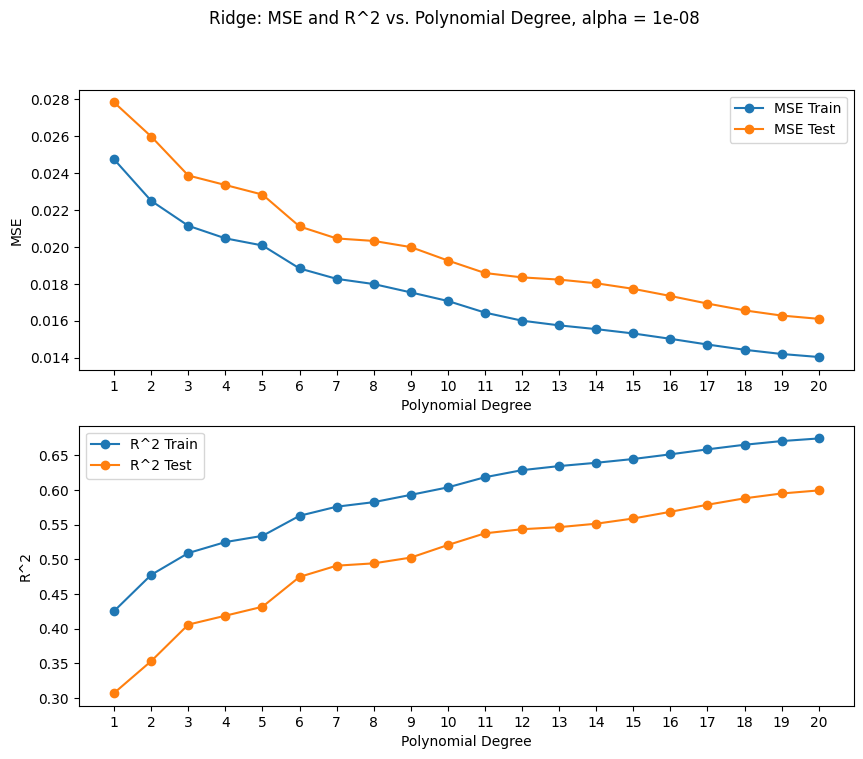

train error:0.014028248611051704
test error:0.01609916666383808


In [11]:
for degree in range(1, PolynomialDegree + 1):
    # Find the index of the lambda with the minimum MSE Test for the current degree
    min_mse_lambda_idx = np.argmin(MSETest[:, degree-1])
    
    # Get the lambda value and the corresponding minimum MSE Test
    min_mse_lambda = lambdas[min_mse_lambda_idx]
    min_mse_value = MSETest[min_mse_lambda_idx, degree-1]
    
    print(f"Degree {degree}: Minimum MSE Test = {min_mse_value} (Lambda = {min_mse_lambda})")
degrees = np.arange(1, PolynomialDegree + 1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(degrees, MSETrain[0], label='MSE Train', marker = 'o')
ax1.plot(degrees, MSETest[0], label='MSE Test', marker = 'o')
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('MSE')
ax1.set_xticks(ticks = degrees)
ax1.legend()
plt.suptitle(f"MSE and R^2 vs. Polynomial Degree, alpha = {lambdas[0]}")
ax2.plot(degrees, R2Train[0], label='R^2 Train', marker = 'o')
ax2.plot(degrees, R2Test[0], label='R^2 Test', marker = 'o')
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('R^2')
ax2.set_xticks(ticks = degrees)
ax2.legend()
plt.suptitle(f"Ridge: MSE and R^2 vs. Polynomial Degree, alpha = {lambdas[0]}")
plt.show()

print(f"train error:{MSETrain[0][19]}")
print(f"test error:{MSETest[0][19]}")

In [13]:
##Lasso

warnings.filterwarnings("ignore", category=ConvergenceWarning)
                        
nlambdas = 100
lambdas = np.logspace(-8, 2, nlambdas)

MSETrain = np.zeros((nlambdas, PolynomialDegree))
MSETest = np.zeros((nlambdas, PolynomialDegree))
R2Train = np.zeros((nlambdas, PolynomialDegree))
R2Test = np.zeros((nlambdas, PolynomialDegree))   


for lmbd in range(nlambdas):
    for degree in range(1, PolynomialDegree + 1):    
        c, Xtilde = c_tilde(degree, x_train)
        model = linear_model.Lasso(lambdas[lmbd])
        model.fit(Xtilde, z_train)

        ztilde = model.predict(Xtilde)
        z_pred = model.predict(x_test[:,0:c-1])

        MSETrain[lmbd, degree -1] = mean_squared_error(z_train, ztilde)
        MSETest[lmbd, degree-1] = mean_squared_error(z_test, z_pred)
        R2Train[lmbd, degree-1] = r2_score(z_train, ztilde)
        R2Test[lmbd, degree-1] = r2_score(z_test, z_pred)
    


Degree 1: Minimum MSE Test = 0.027539288026062796 (Lambda = 0.003593813663804626)
Degree 2: Minimum MSE Test = 0.02597034241767779 (Lambda = 0.00010974987654930568)
Degree 3: Minimum MSE Test = 0.02385229704739233 (Lambda = 1e-08)
Degree 4: Minimum MSE Test = 0.02391306919548697 (Lambda = 1e-08)
Degree 5: Minimum MSE Test = 0.023683494836703407 (Lambda = 1e-08)
Degree 6: Minimum MSE Test = 0.02331247562720797 (Lambda = 1e-08)
Degree 7: Minimum MSE Test = 0.023040275431084604 (Lambda = 1e-08)
Degree 8: Minimum MSE Test = 0.022849741187859346 (Lambda = 1e-08)
Degree 9: Minimum MSE Test = 0.022614831718137055 (Lambda = 1e-08)
Degree 10: Minimum MSE Test = 0.02235664589452972 (Lambda = 1e-08)
Degree 11: Minimum MSE Test = 0.022128974428515392 (Lambda = 1e-08)
Degree 12: Minimum MSE Test = 0.021962030079286942 (Lambda = 1e-08)
Degree 13: Minimum MSE Test = 0.02186731693702567 (Lambda = 1e-08)
Degree 14: Minimum MSE Test = 0.02184098651959782 (Lambda = 1e-08)
Degree 15: Minimum MSE Test = 0.

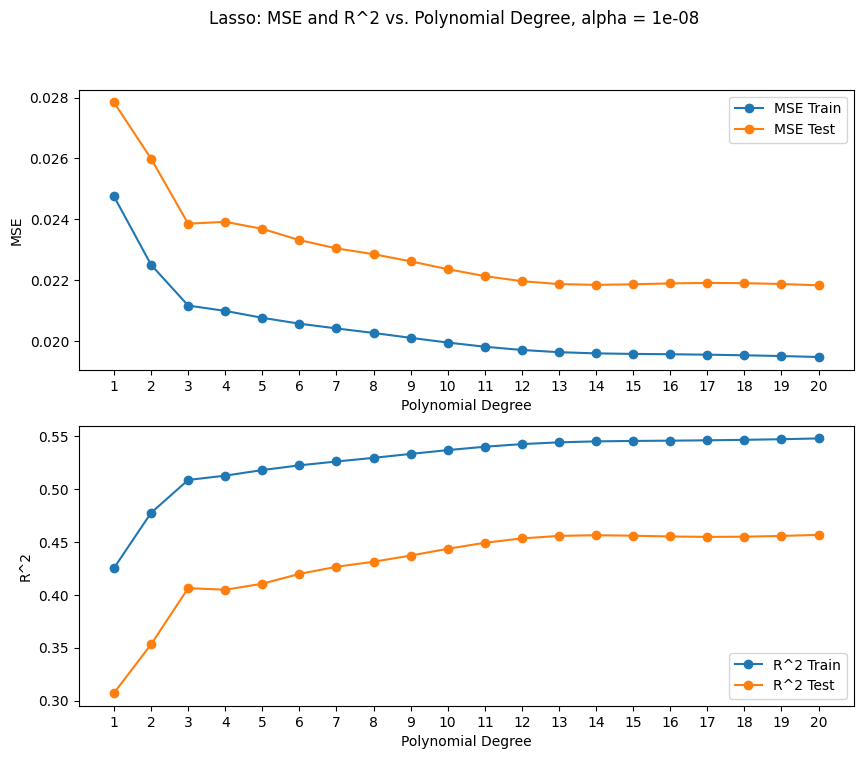

train error:0.019470000225800733
test error:0.02182686463758756


In [14]:
for degree in range(1, PolynomialDegree + 1):
    # Find the index of the lambda with the minimum MSE Test for the current degree
    min_mse_lambda_idx = np.argmin(MSETest[:, degree-1])
    
    # Get the lambda value and the corresponding minimum MSE Test
    min_mse_lambda = lambdas[min_mse_lambda_idx]
    min_mse_value = MSETest[min_mse_lambda_idx, degree-1]
    
    print(f"Degree {degree}: Minimum MSE Test = {min_mse_value} (Lambda = {min_mse_lambda})")
degrees = np.arange(1, PolynomialDegree + 1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(degrees, MSETrain[0], label='MSE Train', marker = 'o')
ax1.plot(degrees, MSETest[0], label='MSE Test', marker = 'o')
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('MSE')
ax1.set_xticks(ticks = degrees)
ax1.legend()
plt.suptitle(f"MSE and R^2 vs. Polynomial Degree, alpha = {lambdas[0]}")
ax2.plot(degrees, R2Train[0], label='R^2 Train', marker = 'o')
ax2.plot(degrees, R2Test[0], label='R^2 Test', marker = 'o')
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('R^2')
ax2.set_xticks(ticks = degrees)
ax2.legend()
plt.suptitle(f"Lasso: MSE and R^2 vs. Polynomial Degree, alpha = {lambdas[0]}")
plt.show()

print(f"train error:{MSETrain[0][19]}")
print(f"test error:{MSETest[0][19]}")

In [9]:
n_boostraps = 100
maxdegree = 20

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

for degree in range(1, maxdegree + 1):
    c, Xtilde = c_tilde(degree, x_train)
    
    model = LinearRegression(fit_intercept = True)

    y_pred = np.empty((z_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_ = resample(Xtilde, z_train)
        y_pred[:, i] = model.fit(x_, y_).predict(x_test[:, 0:c - 1]).ravel()
        
    polydegree[degree - 1] = degree
    error[degree - 1] = np.mean(np.mean((z_test - y_pred)**2, axis=1, keepdims=True))
    bias[degree - 1] = np.mean((z_test - np.mean(y_pred, axis=1, keepdims=True))**2)
    variance[degree - 1] = np.mean(np.var(y_pred, axis=1, keepdims=True))



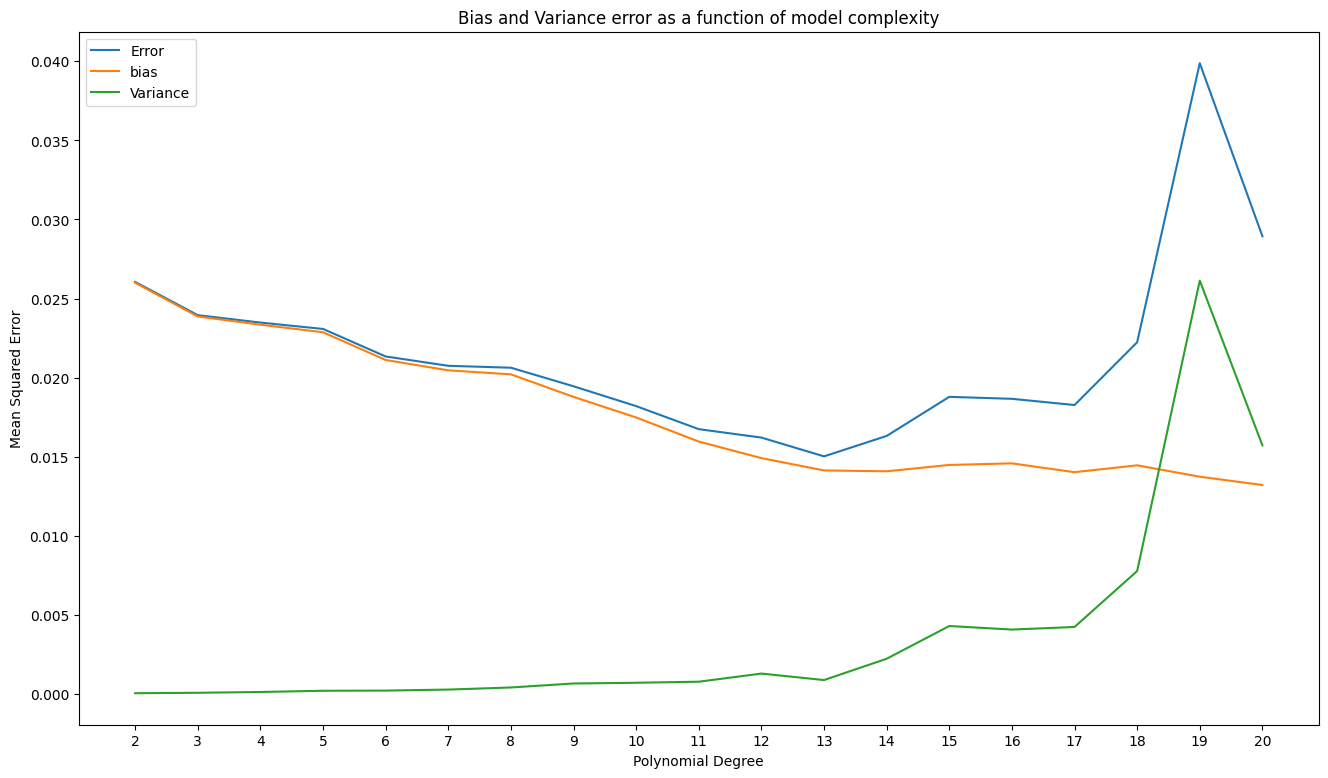

In [16]:
plt.figure(figsize=(16,9))
plt.plot(polydegree[1:], error[1:], label='Error')
plt.plot(polydegree[1:] , bias[1:], label='bias')
plt.plot(polydegree[1:], variance[1:], label='Variance')
plt.xlabel("Polynomial Degree", fontsize = 16)
plt.ylabel("Mean Squared Error", fontsize = 16)
plt.title("Bias and Variance error as a function of model complexity", fontsize = 20)
plt.xticks(ticks = polydegree[1:])
plt.legend(fontsize = 16)
plt.show()

5-Kfold : The lowest MSE value is : 0.00E+00 at polynomial degree 19
10-Kfold : The lowest MSE value is : 0.00E+00 at polynomial degree 19
20-Kfold : The lowest MSE value is : 0.00E+00 at polynomial degree 19


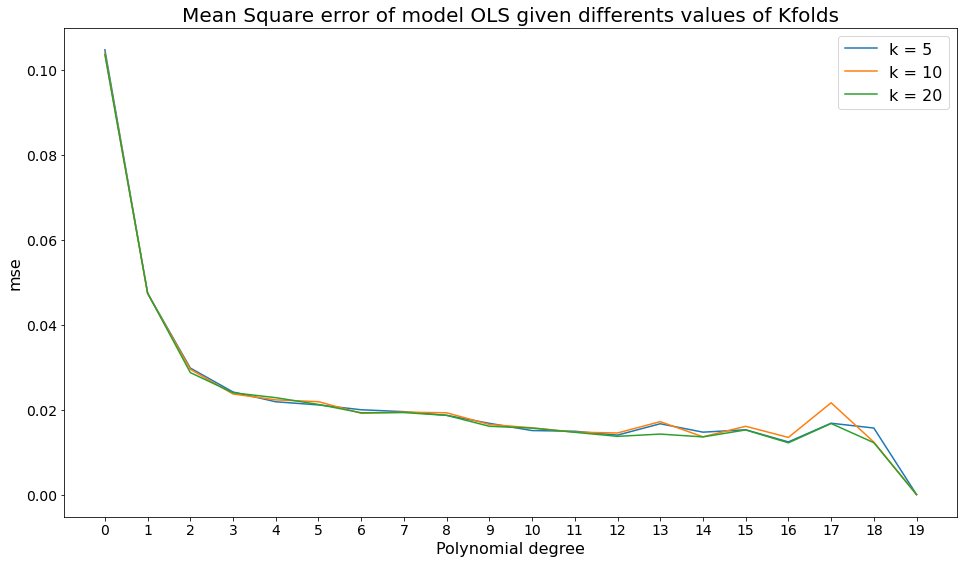

5-Kfold : The lowest MSE value is : 0.0141021980 at for lambda = 3.6783797718286343e-10
10-Kfold : The lowest MSE value is : 0.0138014094 at for lambda = 1.6297508346206467e-10
20-Kfold : The lowest MSE value is : 0.0137413987 at for lambda = 1.6297508346206467e-10


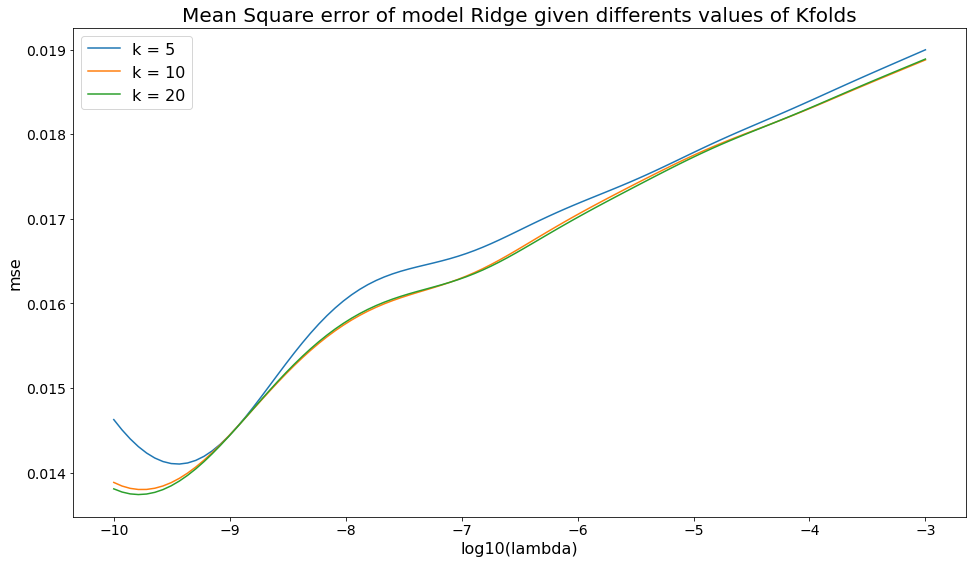

In [32]:
np.random.seed(1509)
nlambdas = 100
lambdas = np.logspace(-10, -3, nlambdas)

mseOLS_5 = np.zeros(PolynomialDegree)
mseOLS_10 = np.zeros(PolynomialDegree)
mseOLS_20 = np.zeros(PolynomialDegree)

mseRidge_5 = np.zeros(nlambdas)
mseRidge_10 = np.zeros(nlambdas)
mseRidge_20 = np.zeros(nlambdas)

mseLasso_5 = np.zeros(nlambdas)
mseLasso_10 = np.zeros(nlambdas)
mseLasso_20 = np.zeros(nlambdas)

k_dict_ols = {
        5: mseOLS_5,
        10: mseOLS_10,
        20: mseOLS_20
    }

k_dict_ridge = {
        5: mseRidge_5,
        10: mseRidge_10,
        20: mseRidge_20
    }

k_dict_lasso = {
        5: mseLasso_5,
        10: mseLasso_10,
        20: mseLasso_20
    }

z_train = z_train.ravel()

def k_fold_scikit(lambdas, k_dict, method):
    plt.figure(figsize=(16,9))
    for k, k_array in k_dict.items():
        kfold = KFold(n_splits = k)
        i = 0
        for lmbd in lambdas:
            match method:
                case "Ridge":
                    model = Ridge(alpha=lmbd)
                case "Lasso":
                    model = Lasso(alpha=lmbd)
            mse_folds = cross_val_score(model, x_train, z_train[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)
            k_array[i] = np.mean(-mse_folds)
            i += 1
        plt.plot(np.log10(lambdas), k_array, label = f'k = {k}')
        print(f"{k}-Kfold : The lowest MSE value is : {k_array[np.argmin(k_array)]:.10f} at for lambda = {lambdas[np.argmin(k_array)]}")
    plt.xlabel('log10(lambda)', fontsize = 16)
    plt.ylabel('mse', fontsize = 16)
    plt.xticks(fontsize=14)  
    plt.legend(fontsize=16)
    plt.yticks(fontsize=14)
    plt.title(f"Mean Square error of model {method} given differents values of Kfolds", fontsize=20)
    plt.show()

def k_fold_scikit_ols(PolynomialDegree, k_dict):
    plt.figure(figsize=(16,9))
    for k, k_array in k_dict.items():
        kfold = KFold(n_splits = k)
        i = 0
        for degree in range(1,PolynomialDegree):
            #create design matrix X
            X = create_X(datapoints[:, 0], datapoints[:, 1], degree)
            #Remove intercept
            X = X[:, 1:]
            #Split into train and test sets
            x_train, x_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)
            z_train = z_train.ravel()
            model = LinearRegression(fit_intercept=False)
            mse_folds = cross_val_score(model, x_train, z_train, scoring='neg_mean_squared_error', cv=kfold)
            k_array[i] = np.mean(-mse_folds)
            i += 1
        plt.plot(np.arange(0,PolynomialDegree,1), k_array, label = f'k = {k}')
        print(f"{k}-Kfold : The lowest MSE value is : {k_array[np.argmin(k_array)]:.2E} at polynomial degree {np.argmin(k_array)}")
    plt.xlabel('Polynomial degree', fontsize = 16)
    plt.ylabel('mse', fontsize = 16)
    plt.xticks(np.arange(0,PolynomialDegree,1),fontsize=14)  
    plt.legend(fontsize=16)
    plt.yticks(fontsize=14)
    plt.title(f"Mean Square error of model OLS given differents values of Kfolds", fontsize=20)
    plt.show()

k_fold_scikit_ols(PolynomialDegree, k_dict_ols)
k_fold_scikit(lambdas, k_dict_ridge, "Ridge")
# k_fold_scikit(lambdas, k_dict_lasso, "Lasso")